In [ ]:
!pip install pytorch-lightning

In [ ]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pytorch_lightning as pl

In [ ]:
torch.manual_seed(200)
np.random.seed(200)

# set pandas to better show our data
pd.set_option('display.max_columns', None)
pd.set_option('expand_frame_repr', False)

In [ ]:
df=pd.read_csv("/content/electricityConsumptionAndProductioction.csv.zip")
df1=pd.read_csv("/content/bombay[1].csv")
df

DateTime  Consumption  Production  Nuclear  Wind  Hydroelectric  Oil and Gas  Coal  Solar  Biomass
0      2019-01-01 00:00:00         6352        6527     1395    79           1383         1896  1744      0       30
1      2019-01-01 01:00:00         6116        5701     1393    96           1112         1429  1641      0       30
2      2019-01-01 02:00:00         5873        5676     1393   142           1030         1465  1616      0       30
3      2019-01-01 03:00:00         5682        5603     1397   191            972         1455  1558      0       30
4      2019-01-01 04:00:00         5557        5454     1393   159            960         1454  1458      0       30
...                    ...          ...         ...      ...   ...            ...          ...   ...    ...      ...
36767  2023-03-12 19:00:00         6500        6643     1407   111           3084          933  1047      0       60
36768  2023-03-12 20:00:00         6471        6484     1408    58           2983          933  1042      0       60
36769  2023-03-12 21:00:00         6194        6413     1406    39           2938          935  1031      0       62
36770  2023-03-12 22:00:00         5708        6217     1406     8           2823          917  1001      0       61
36771  2023-03-12 23:00:00         5409        5900     1403     0           2492          914  1030      0       60

[36772 rows x 10 columns]

Preprocessing

In [ ]:
df.drop(["Production", "Nuclear", "Wind", "Hydroelectric", "Oil and Gas", "Coal", "Solar", "Biomass"], axis=1, inplace=True)
df

DateTime  Consumption
0      2019-01-01 00:00:00         6352
1      2019-01-01 01:00:00         6116
2      2019-01-01 02:00:00         5873
3      2019-01-01 03:00:00         5682
4      2019-01-01 04:00:00         5557
...                    ...          ...
36767  2023-03-12 19:00:00         6500
36768  2023-03-12 20:00:00         6471
36769  2023-03-12 21:00:00         6194
36770  2023-03-12 22:00:00         5708
36771  2023-03-12 23:00:00         5409

[36772 rows x 2 columns]

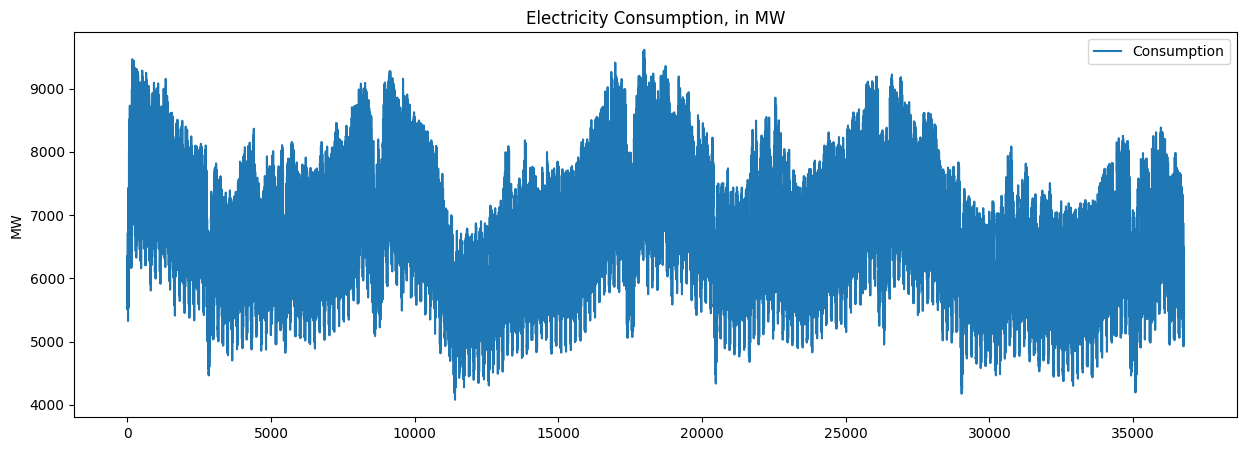

In [ ]:
df[["Consumption"]].plot(style="-", figsize=(15, 5), title="Electricity Consumption, in MW")
plt.ylabel('MW')
plt.show()

Sequencing the data

In [ ]:
start_date = '2024-01-01 00:00:00'
end_date = '2024-01-31 23:00:00'

# Create a date range with hourly frequency
hourly_timestamps = pd.date_range(start=start_date, end=end_date, freq='H')

In [ ]:
sequenceSize = 8

# let's compute a cutoff index that will separate the training and the test data
testCutOffIndex = int(len(df) * 0.97)

# also we should keep test date times in order to later do some nice plotting
testDates = df[testCutOffIndex + sequenceSize: len(df)]["DateTime"]

df = df["Consumption"]

train = df[0: testCutOffIndex]
test = df[testCutOffIndex:]

# the scaler wants a bi dimensional array [[1], [2], [3]], insstead of [1, 2, 3]
train = train.to_numpy().reshape(-1, 1)
test = test.to_numpy().reshape(-1, 1)
testDates

35676    2023-01-26 08:00:00
35677    2023-01-26 09:00:00
35678    2023-01-26 10:00:00
35679    2023-01-26 11:00:00
35680    2023-01-26 12:00:00
                ...         
36767    2023-03-12 19:00:00
36768    2023-03-12 20:00:00
36769    2023-03-12 21:00:00
36770    2023-03-12 22:00:00
36771    2023-03-12 23:00:00
Name: DateTime, Length: 1096, dtype: object

In [ ]:
# in order for our neural network to work better we should scale the values
scaler = StandardScaler()
train = scaler.fit_transform(train).flatten().tolist()
test = scaler.transform(test).flatten().tolist()

In [ ]:
def toSequence(data, sequenceSize):
    X = []
    y = []

    for i in range(len(data) - sequenceSize):
        window = data[i: (i + sequenceSize)]
        target = data[i + sequenceSize]

        X.append(window)
        y.append(target)
        #print(torch.tensor(X, dtype=torch.float32).reshape(-1, sequenceSize, 1), torch.tensor(y, dtype=torch.float32).reshape(-1, 1))
    return torch.tensor(X, dtype=torch.float32).reshape(-1, sequenceSize, 1), torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

In [ ]:
xTrain, yTrain = toSequence(train, sequenceSize)
xTest, yTest = toSequence(test, sequenceSize)

Creating LSTM

In [ ]:
class ElectricityLstm(pl.LightningModule):
    def __init__(self):
        super(ElectricityLstm, self).__init__()

        self.lossFunction = nn.MSELoss()

        self.lstm = nn.LSTM(input_size=1, hidden_size=32, batch_first=True)
        self.droput = nn.Dropout(0.1)

        self.fc1 = nn.Linear(in_features=32, out_features=16)
        self.fc2 = nn.Linear(in_features=16, out_features=1)

    def forward(self, X):
        out, _ = self.lstm(X)
        out = out[:, -1, :]
        out = self.droput(out)
        out = self.fc1(out)
        out = self.fc2(out)

        return out


    def training_step(self, batch, batchIndex):
        X, y = batch
        out = self(X)
        loss = self.lossFunction(out, y)

        return {"loss": loss}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.00001)

Traning the model

In [ ]:
train_dataset = TensorDataset(xTrain, yTrain)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = TensorDataset(xTest, yTest)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
numberOfEpochs = 5

model = ElectricityLstm()

trainer = pl.Trainer(max_epochs = numberOfEpochs)

model.train()

trainer.fit(model, train_loader)

model.eval()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type    | Params
-----------------------------------------
0 | lossFunction | MSELoss | 0     
1 | lstm         | LSTM    | 4.5 K 
2 | droput       | Dropout | 0     
3 | fc1          | Linear  | 528   
4 | fc2          | Linear  | 17    
-----------------------------------------
5.0 K     Trainable params
0         Non-trainable params
5.0 K     Total params
0.020     Total estimated model params size (MB)
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the va

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


ElectricityLstm(
  (lossFunction): MSELoss()
  (lstm): LSTM(1, 32, batch_first=True)
  (droput): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=32, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
)

Calculating loss

In [ ]:
predictions = []
actualLabels = []

for batch in test_loader:
    X, y = batch
    prediction = model(X)

    predictions.extend(prediction.detach().numpy().flatten())
    actualLabels.extend(y.detach().numpy().flatten())

In [ ]:
scaledPredictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
scaledYTest = scaler.inverse_transform(np.array(actualLabels).reshape(-1, 1))

In [ ]:
averageLoss = np.sqrt(np.mean((scaledPredictions - scaledYTest) ** 2))

print(f"averageLoss: {averageLoss}")

averageLoss: 437.8009948730469


Prediction

(array([  0,  40,  80, 120, 160]),
 [Text(0, 0, '2023-01-26 08:00:00'),
  Text(40, 0, '2023-01-28 00:00:00'),
  Text(80, 0, '2023-01-29 16:00:00'),
  Text(120, 0, '2023-01-31 08:00:00'),
  Text(160, 0, '2023-02-02 00:00:00')])

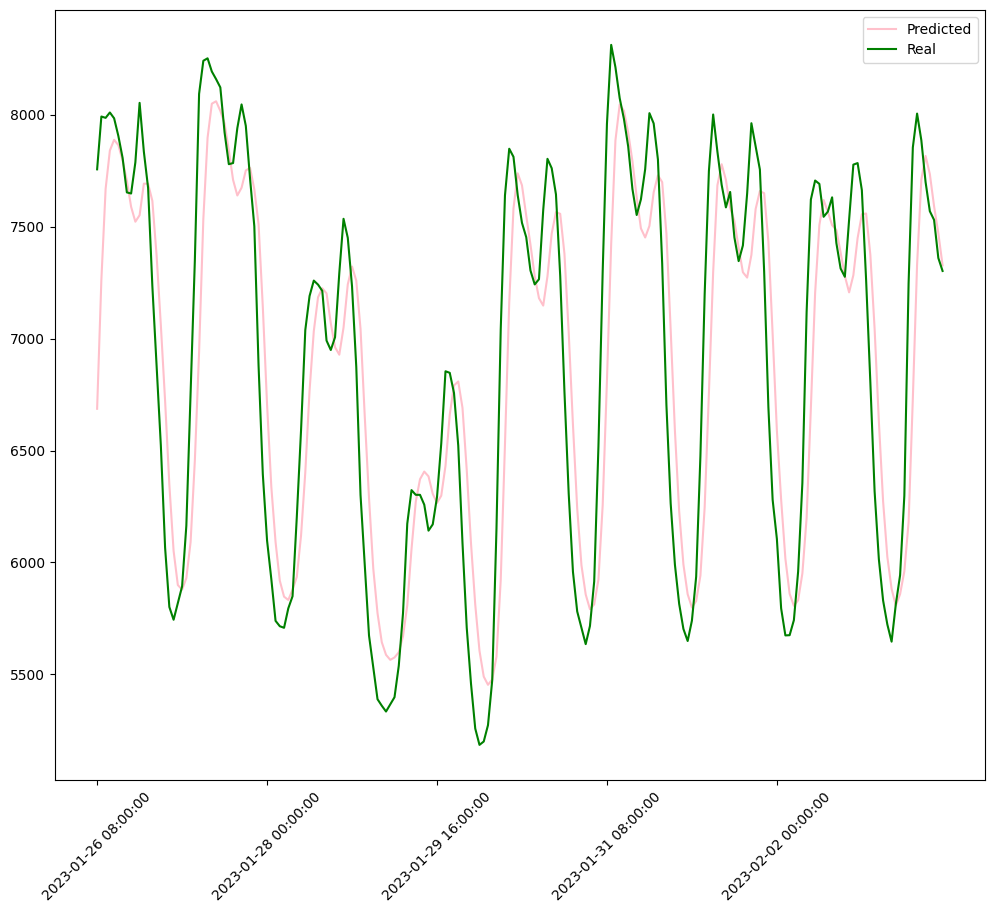

In [ ]:
dataSetSize = 200

plt.figure(figsize=(12,10))
plt.plot(testDates[:dataSetSize], scaledPredictions[:dataSetSize], color= "pink")
plt.plot(testDates[:dataSetSize], scaledYTest[:dataSetSize], color= "green")
plt.legend(["Predicted", "Real"])
plt.xticks(np.arange(0, dataSetSize, round((dataSetSize / 5)/10)*10))
plt.xticks(rotation=45)

In [ ]:
print(scaledPredictions)

[[6918.8286]
 [6918.8286]
 [6436.1064]
 ...
 [6607.0083]
 [6101.447 ]
 [5504.2686]]


In [ ]:
!pip install keras

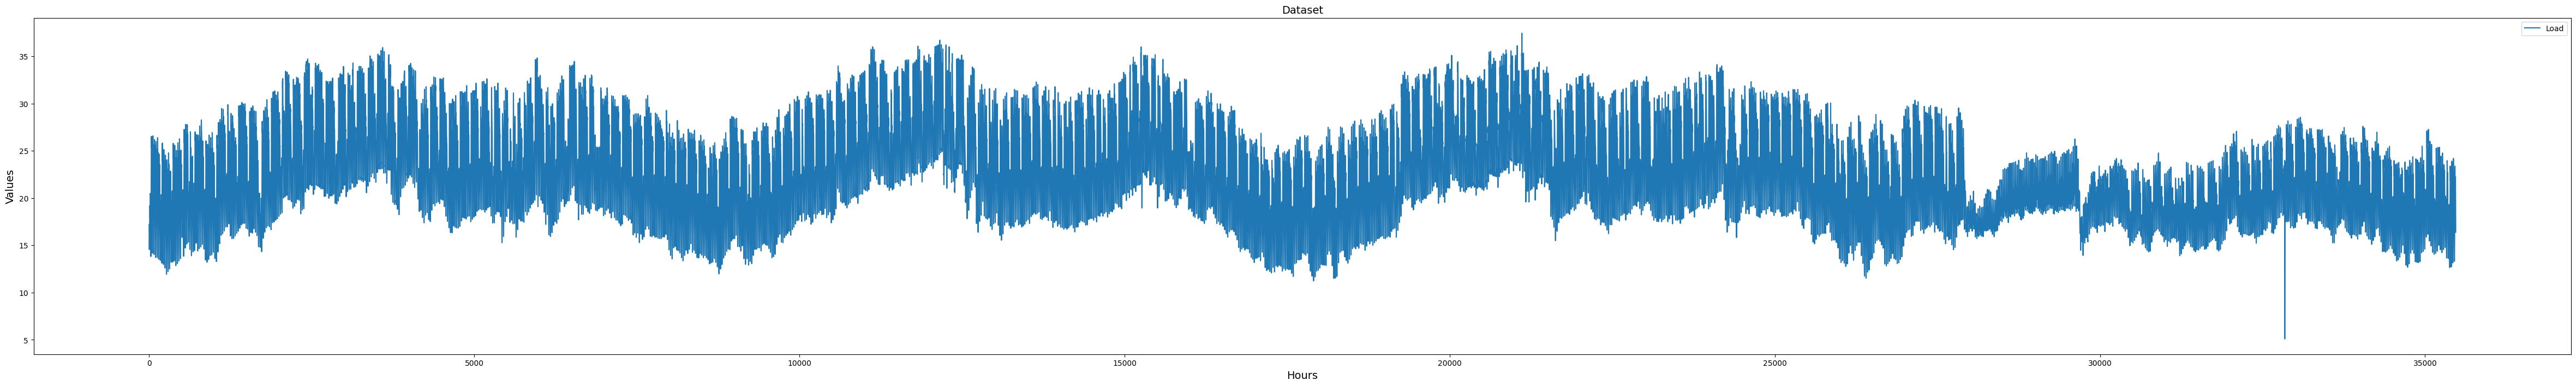

X_train:  (31904, 23) 
 [[-6.10699781 -4.24699781 -2.24699781 ... -8.40699781 -8.68699781
  -8.17699781]
 [-5.71699781 -4.00699781 -2.34699781 ... -4.39699781 -5.44699781
  -6.18699781]
 [-3.46699781 -4.58699781 -6.64699781 ... -2.83699781 -1.68699781
  -2.26699781]
 ...
 [-1.21699781 -2.33699781 -4.20699781 ...  1.86300219  2.35300219
   1.62300219]
 [-4.33699781 -4.46699781 -3.53699781 ...  1.44300219 -0.33699781
  -2.20699781]
 [-4.60699781 -3.81699781 -2.49699781 ... -6.77699781 -6.87699781
  -5.71699781]] 

y_train (31904,) 
 [-7.79699781 -6.39699781 -2.97699781 ...  0.41300219 -3.44699781
 -4.04699781] 

X_test:  (3545, 23) 
 [[-3.44699781 -1.07699781  0.68300219 ... -7.66699781 -7.19699781
  -6.76699781]
 [-1.07699781  0.68300219  1.54300219 ... -7.19699781 -6.76699781
  -5.47699781]
 [ 0.68300219  1.54300219  1.38300219 ... -6.76699781 -5.47699781
  -3.20699781]
 ...
 [-4.75699781 -6.47699781 -8.02699781 ... -1.25699781 -1.03699781
  -2.10699781]
 [-6.47699781 -8.02699781 -8.94

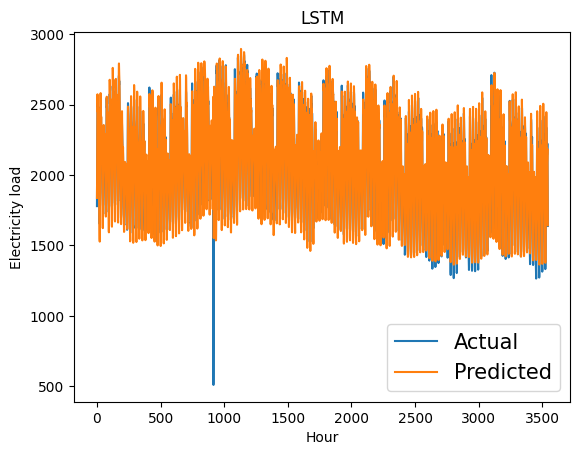

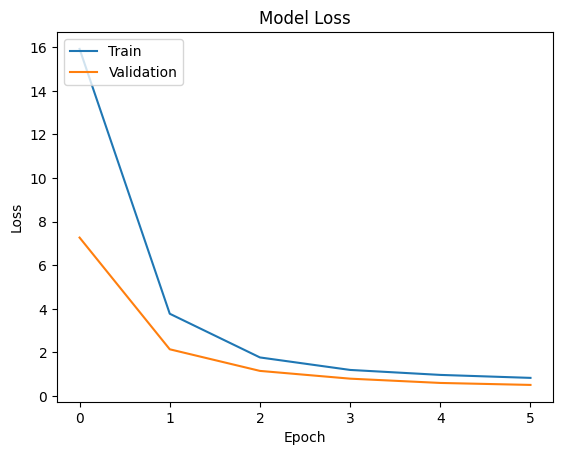

Total time:  162.52895498275757


In [ ]:
from __future__ import print_function
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error
import os
import warnings
from keras.models import load_model

warnings.filterwarnings("ignore", category=DeprecationWarning)

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

start_time = time.time()


# Defining a function to convert a vector of time series into a 2D matrix for faster processing
def convertTimeSeriesTo2DMatrix(vectorSeries, sequence_length):
    matrix = []
    for i in range(len(vectorSeries) - sequence_length + 1):
        matrix.append(vectorSeries[i:i + sequence_length])
    return matrix


np.random.seed(1234)  # Selecting a random seed

# Pre-processing of the data
df_raw = pd.read_csv('/content/hourly_loaddata.csv', header=None, skiprows=1)  # loading raw data from the CSV
df_raw_array = df_raw.values  # numpy array

# daily_load = [df_raw_array[i,:] for i in range(0, len(df_raw)) if i % 24 == 0] # daily load
# print(daily_load)

hourly_load = [df_raw_array[i, 2] / 100 for i in range(0, len(df_raw))]  # hourly load, 24 for each day
# print(hourly_load)

length_of_sequence = 24  # Storing the length of the sequence/hours in the day for predicting the future value

# Converting the vector to a 2D matrix using the function above
hourly_load_matrix = convertTimeSeriesTo2DMatrix(hourly_load, length_of_sequence)

# Shift all the data by mean
hourly_load_matrix = np.array(hourly_load_matrix)
shifted_value = hourly_load_matrix.mean()
hourly_load_matrix = hourly_load_matrix - shifted_value
# print ("Data  shape: ", hourly_load_matrix.shape)
# print(hourly_load_matrix)

# Splitting the dataset into two: 90% for training and 10% for testing
test_row = int(round(0.9 * hourly_load_matrix.shape[0]))
train_set = hourly_load_matrix[:test_row, :]

np.random.shuffle(train_set)  # Shuffling only the training set randomly

# print(train_set, "\n")

dataset_graph = plt.figure(figsize=(60, 8))
plt.plot(hourly_load, label='Load')
plt.legend(loc='upper right')
plt.title("Dataset", fontsize=14)
plt.xlabel('Hours', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.legend()
plt.show()
# dataset_graph.savefig('results/LSTM/dataset_graph.jpg', bbox_inches='tight')

# The Final training set
X_train = train_set[:, :-1]
print("X_train: ",X_train.shape, "\n", X_train, "\n")
y_train = train_set[:, -1]  # The last column is the true value to compute the mean-squared-error loss
print("y_train",y_train.shape, "\n", y_train, "\n")

# The Final testing set
X_test = hourly_load_matrix[test_row:, :-1]
print("X_test: ",X_test.shape, "\n", X_test, "\n")
y_test = hourly_load_matrix[test_row:, -1]
print("y_test: ",y_test.shape,"\n", y_test, "\n")

# The input to LSTM layer needs to have the shape of (number of samples, the dimension of each element)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Building the LSTM model
model = Sequential()

# Layer 1: LSTM
model.add(LSTM(input_dim=1, units=50, return_sequences=True))
model.add(Dropout(0.2))  # Reducing overfitting and improving model performance

# Layer 2: LSTM
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))  # Reducing overfitting and improving model performance

# Layer 3: Dense
model.add(Dense(units=1, activation='linear'))

# Compiling the model
model.compile(loss="mse", optimizer="adam")
es = EarlyStopping(monitor="val_loss", min_delta=0, patience=5, verbose=1, mode="auto", baseline=None,
                   restore_best_weights=True)  # Stops the training when the values don't improve

#Values taken from the above
final_batch_size = 1024
final_epoch = 6
# Training the best model
history = model.fit(X_train, y_train, batch_size=final_batch_size, epochs=final_epoch, validation_split=0.05, verbose=1,
          callbacks=[es])
print(model.summary())

model.save('assets/univariate/lstm.tf', overwrite=True, include_optimizer=True)
# loaded_model = load_model('path')

# Evaluating the result
test_mse = model.evaluate(X_test, y_test, verbose=1)
print('\nThe Mean-squared-error (MSE) on the test data set is %.6f over %d test samples.' % (test_mse, len(y_test)))

# Getting the predicted values
predicted_values = model.predict(X_test)
num_test_samples = len(predicted_values)
predicted_values = np.reshape(predicted_values, (num_test_samples, 1))
# print(predicted_values)
print('The MSE value is:',
      mean_squared_error((predicted_values + shifted_value) * 100, (y_test + shifted_value) * 100, squared=True))
print('The RMSE value is:',
      mean_squared_error((predicted_values + shifted_value) * 100, (y_test + shifted_value) * 100, squared=False))
print('The R-squared value is:', r2_score(predicted_values + shifted_value, y_test + shifted_value))
print('The MAPE value is:', np.mean(np.abs(((y_test+shifted_value) - np.reshape(predicted_values+shifted_value, (3545,))) / (y_test+shifted_value))) * 100,'\n')

# Plotting the results
fig = plt.figure()
plt.plot((y_test + shifted_value) * 100)
plt.plot((predicted_values + shifted_value) * 100)
plt.title("LSTM")
plt.xlabel('Hour')
plt.ylabel('Electricity load')
plt.legend(('Actual', 'Predicted'), fontsize='15')
plt.show()


# Plot of the loss
loss_fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
#loss_fig.savefig('results/LSTM/final_loss.jpg', bbox_inches='tight')

# Storing the result in a file: 'load_forecasting_result.txt'
#

end_time = time.time()

print("Total time: ", end_time - start_time)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

---------------------------------------------------------


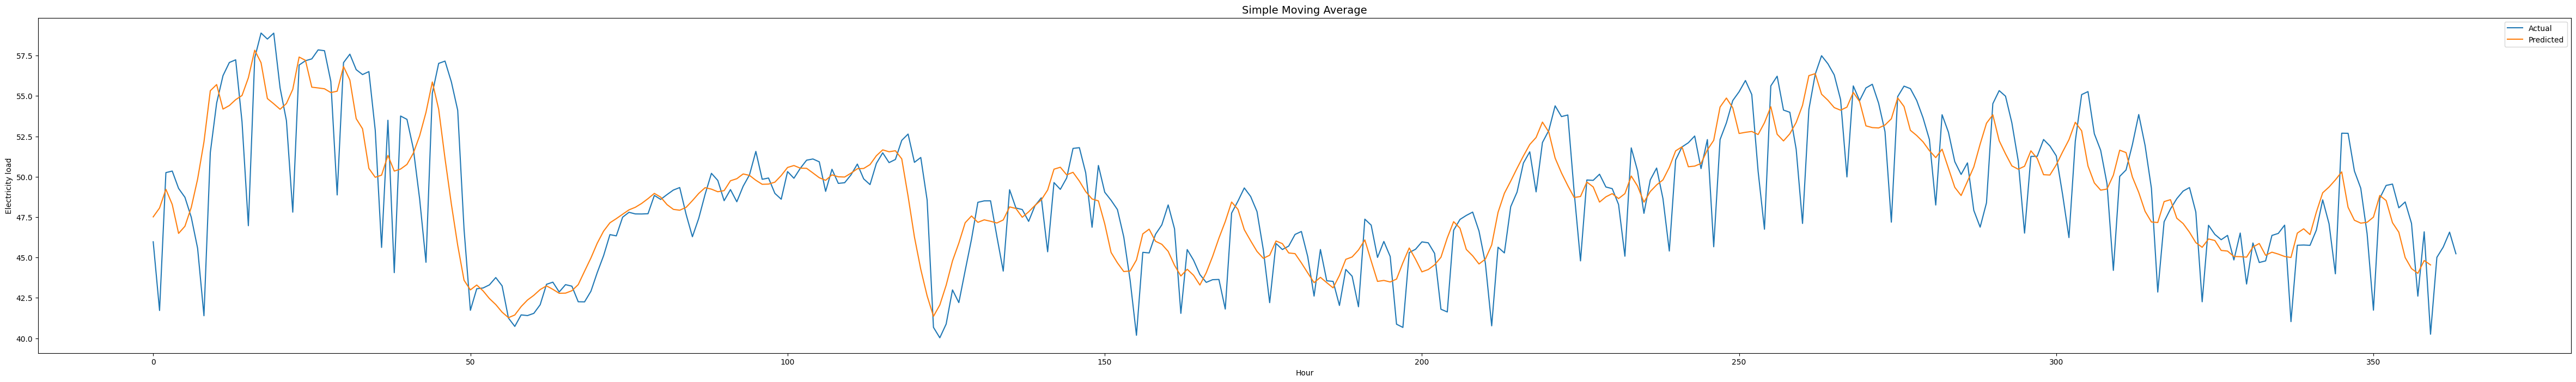

MSE for SMA:  6.79369875922222
RMSE for SMA: 2606.4724742882327
R-squared for SMA: 0.5020577310943233
MAPE for SMA: 4.010782455801165
---------------------------------------------------------


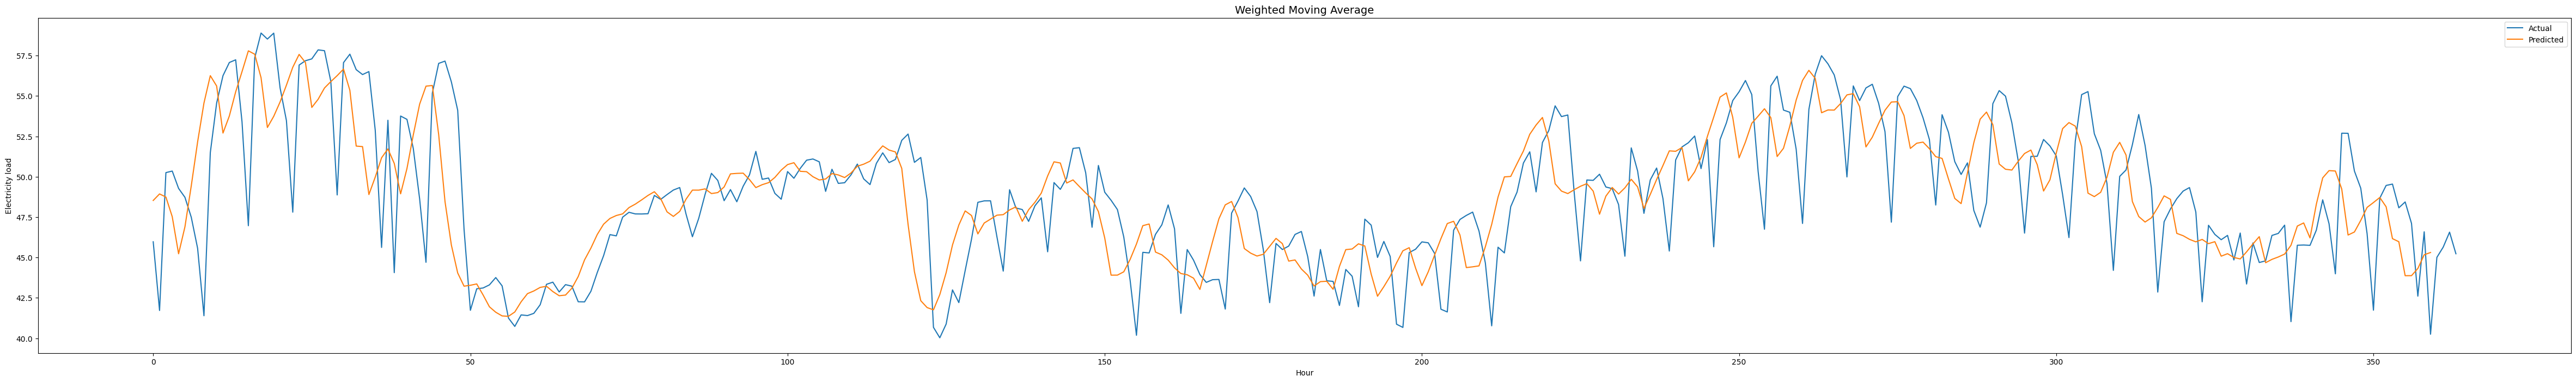

MSE for WMA:  4.110031209370371
RMSE for WMA: 2027.3211904802777
R-squared for WMA: 0.7111574168909791
MAPE for WMA: 3.128610703176565
---------------------------------------------------------


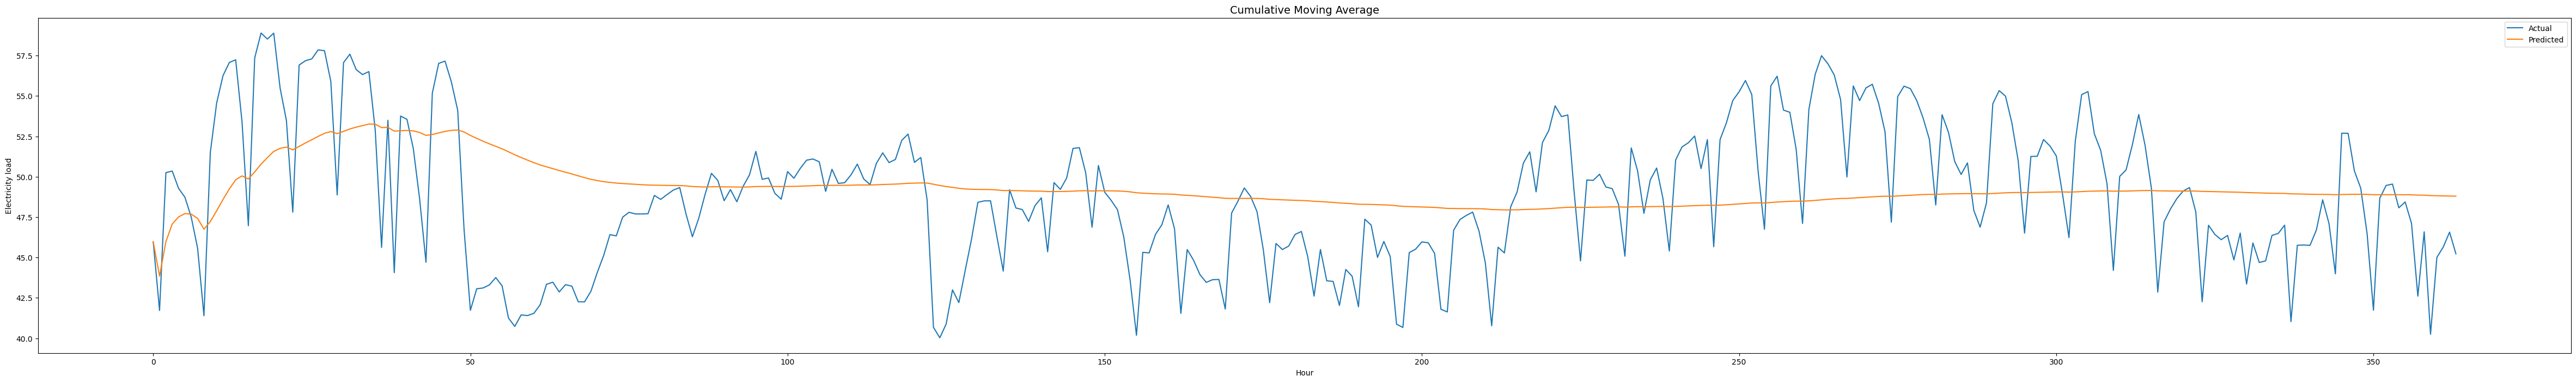

MSE for CMA:  18.62111860722196
RMSE for CMA: 4315.219415883966
R-squared for CMA: -9.53783481092755
MAPE for CMA: 0    7.224245
dtype: float64
---------------------------------------------------------


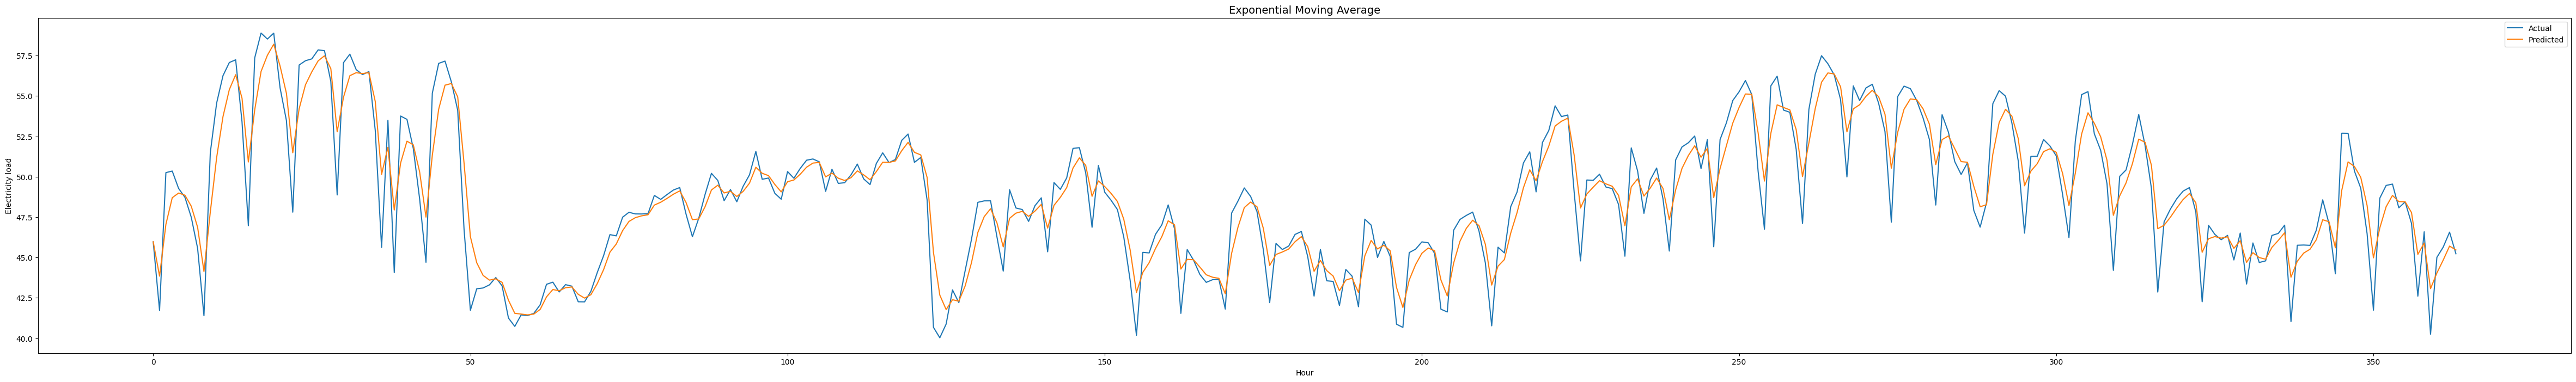

MSE for EMA:  2.1136976290104155
RMSE for EMA: 1453.8561239030553
R-squared for EMA: 0.8563860017458871
MAPE for EMA: 0    2.230758
dtype: float64
---------------------------------------------------------


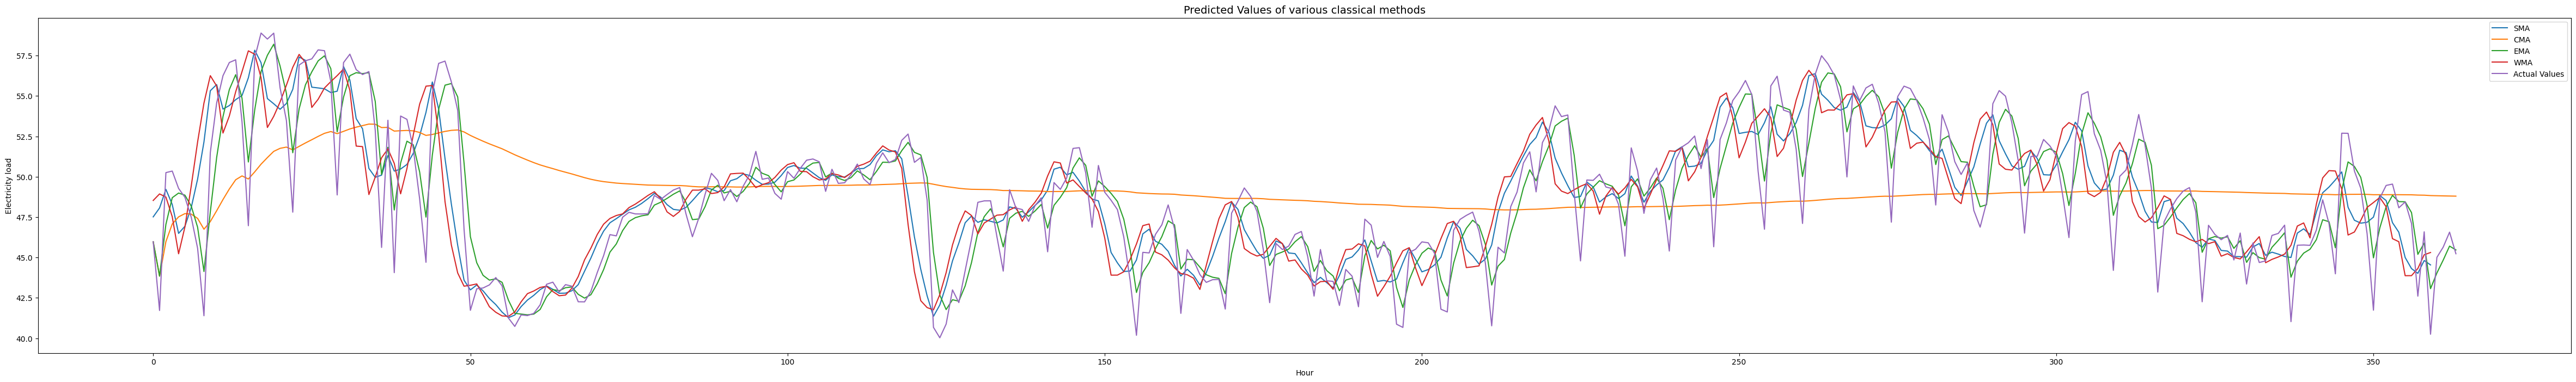

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Pre-processing of the data
df_raw = pd.read_csv('hourly_load&weather_data.csv', header=None, skiprows=1)  # loading raw data from the CSV
y_test = df_raw[1].values/1000  # numpy array
# print("y_test: ", y_test.shape, "\n", y_test, "\n")


def simple_moving_average(n, y_test):
    # Getting the predicted values for SMA
    y_pred = pd.Series(y_test).rolling(window=n).mean().iloc[n - 1:].values
    # print("Predicted values: ", y_pred, "\n")
    mse_sma = mean_squared_error(y_test[n - 1:], y_pred)

    # Plotting the results
    fig = plt.figure(figsize=(60, 8))
    plt.plot(y_test, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.legend(loc='upper right')
    plt.title("Simple Moving Average", fontsize=14)
    plt.xlabel('Hour')
    plt.ylabel('Electricity load')
    plt.show()

    # Storing the result in a file: 'load_forecasting_result.txt'
    predicted_test_result = y_pred
    actual_test_result = y_test

    return mse_sma, y_pred


def weighted_moving_average(n, y_test):
    y_pred = []
    for i in range(len(y_test) - 4):
        total = np.arange(1, n + 1, 1)  # Weight Matrix for current being the heaviest
        temp = y_test[i:i + n]
        temp = total * temp
        wma = (temp.sum()) / (total.sum())
        y_pred = np.append(y_pred, wma)

    # print("Predicted values: ", y_pred, "\n")
    mse_wma = mean_squared_error(y_test[n - 1:], y_pred)

    # Plotting the results
    fig = plt.figure(figsize=(60, 8))
    plt.plot(y_test, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.legend(loc='upper right')
    plt.title("Weighted Moving Average", fontsize=14)
    plt.xlabel('Hour')
    plt.ylabel('Electricity load')
    plt.show()

    # Storing the result in a file: 'load_forecasting_result.txt'
    predicted_test_result = y_pred
    actual_test_result = y_test

    return mse_wma, y_pred


def cumulative_moving_average(y_test):
    df = pd.DataFrame(y_test)
    y_pred = df.expanding().mean()

    # print("Predicted values: ", y_pred, "\n")
    mse_cma = mean_squared_error(y_test, y_pred)

    # Plotting the results
    fig = plt.figure(figsize=(60, 8))
    plt.plot(y_test, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.legend(loc='upper right')
    plt.title("Cumulative Moving Average", fontsize=14)
    plt.xlabel('Hour')
    plt.ylabel('Electricity load')
    plt.show()

    # Storing the result in a file: 'load_forecasting_result.txt'
    predicted_test_result = y_pred


    return mse_cma, y_pred


def exponential_moving_average(y_test):
    df = pd.DataFrame(y_test)
    smoothing_factor = 0.5
    y_pred = df.ewm(alpha=smoothing_factor, adjust=False).mean()

    # print("Predicted values: ", y_pred, "\n")
    mse_ema = mean_squared_error(y_test, y_pred)

    # Plotting the results
    fig = plt.figure(figsize=(60, 8))
    plt.plot(y_test, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.legend(loc='upper right')
    plt.title("Exponential Moving Average", fontsize=14)
    plt.xlabel('Hour')
    plt.ylabel('Electricity load')
    plt.show()


    # Storing the result in a file: 'load_forecasting_result.txt'
    predicted_test_result = y_pred

    actual_test_result = y_test


    return mse_ema, y_pred


print("---------------------------------------------------------")

n = 5  # Window size
mse_sma, y_sma = simple_moving_average(n, y_test)
print("MSE for SMA: ", mse_sma)
print('RMSE for SMA:', mean_squared_error(y_sma * 1000, y_test[n - 1:] * 1000, squared=False))
print('R-squared for SMA:', r2_score(y_sma, y_test[n - 1:]))
print('MAPE for SMA:', np.mean(np.abs((y_test[n-1:] - y_sma) / y_test[n-1:])) * 100)

print("---------------------------------------------------------")

mse_wma, y_wma = weighted_moving_average(n, y_test)
print("MSE for WMA: ", mse_wma)
print('RMSE for WMA:', mean_squared_error(y_wma * 1000, y_test[n - 1:] * 1000, squared=False))
print('R-squared for WMA:', r2_score(y_wma, y_test[n - 1:]))
print('MAPE for WMA:', np.mean(np.abs((y_test[n-1:] - y_wma) / y_test[n-1:])) * 100)

print("---------------------------------------------------------")
y = np.reshape(y_test, (364,1))
mse_cma, y_cma = cumulative_moving_average(y_test)
print("MSE for CMA: ", mse_cma)
print('RMSE for CMA:', mean_squared_error(y_cma * 1000, y * 1000, squared=False))
print('R-squared for CMA:', r2_score(y_cma, y_test))
print('MAPE for CMA:', np.mean(np.abs((y - y_cma) / y)) * 100)

print("---------------------------------------------------------")

mse_ema, y_ema = exponential_moving_average(y_test)
print("MSE for EMA: ", mse_ema)
print('RMSE for EMA:', mean_squared_error(y_ema * 1000, y_test * 1000, squared=False))
print('R-squared for EMA:', r2_score(y_ema, y_test))
print('MAPE for EMA:', np.mean(np.abs((y - y_ema) / y)) * 100)

print("---------------------------------------------------------")


# Plotting the results
fig = plt.figure(figsize=(60, 8))
plt.plot(y_sma, label='SMA')
plt.plot(y_cma, label='CMA')
plt.plot(y_ema, label='EMA')
plt.plot(y_wma, label='WMA')
plt.plot(y_test, label='Actual Values')
plt.legend(loc='upper right')
plt.xlabel('Hour')
plt.ylabel('Electricity load')
plt.title("Predicted Values of various classical methods", fontsize=14)
plt.show()


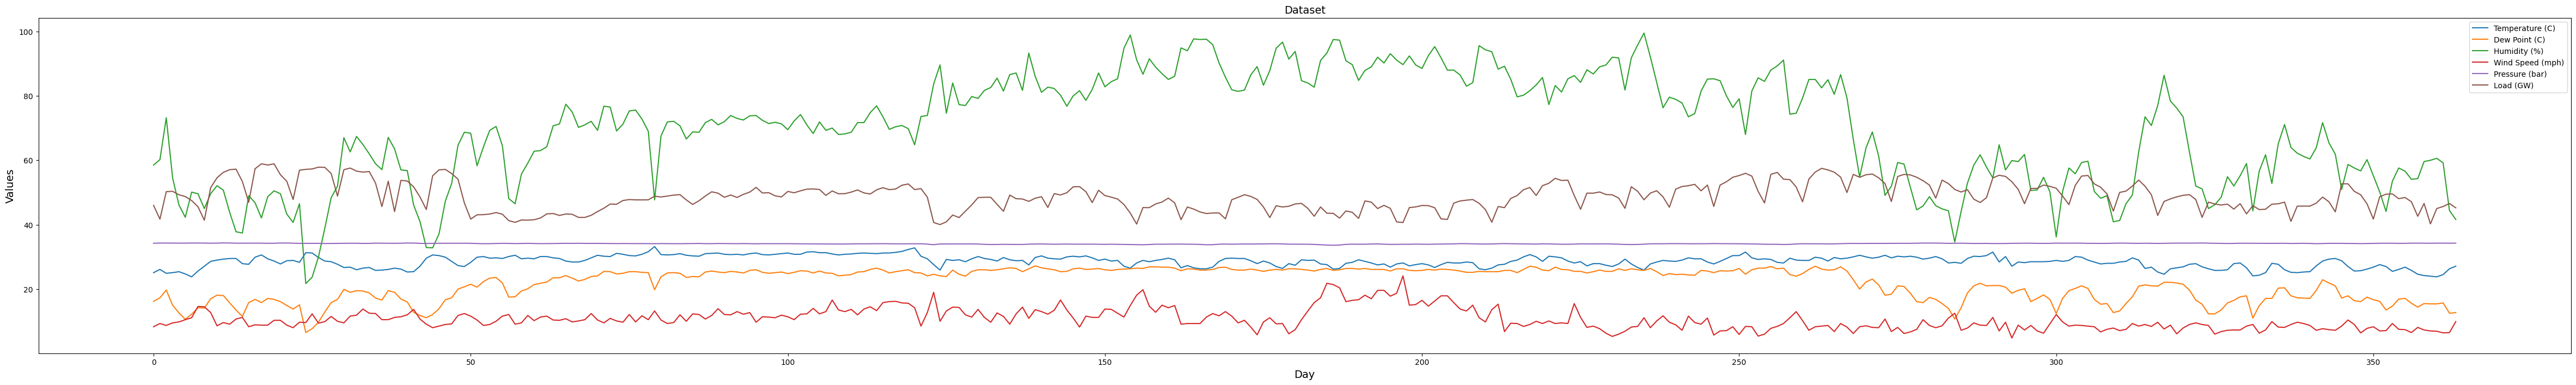


Independent & Dependent variables arrays:
x_temperature: (364, 1)
x_dewpoint: (364, 1)
x_humidity: (364, 1)
x_windspeed: (364, 1)
x_pressure: (364, 1)
y: (364, 1)

Stacked Dataset (364, 6) :
 [[0.13829787 0.46859903 0.47300771 0.18134715 0.86511628 0.31501404]
 [0.24468085 0.52173913 0.49485861 0.23316062 0.95348837 0.08956489]
 [0.11702128 0.63768116 0.66195373 0.20207254 0.94418605 0.54194711]
 ...
 [0.07446809 0.44444444 0.48200514 0.08290155 0.91627907 0.29757804]
 [0.26595745 0.28985507 0.29177378 0.0880829  0.88372093 0.34665324]
 [0.35106383 0.29951691 0.25578406 0.2642487  0.91162791 0.27569029]]

X.shape  (321, 30, 5)
y.shape (321, 15)

train_X (318, 30, 5)
train_y (318, 15)
test_X (3, 30, 5)
test_y (3, 15)
Epoch 1/100
11/11 [==============================] - 6s 102ms/step - loss: 0.2158 - mse: 0.2158 - val_loss: 0.1164 - val_mse: 0.1164
Epoch 2/100
11/11 [==============================] - 0s 35ms/step - loss: 0.2074 - mse: 0.2074 - val_loss: 0.1109 - val_mse: 0.1109
Epoch 3/

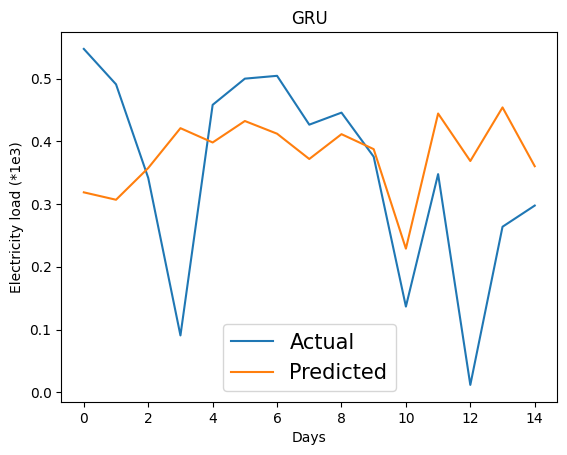

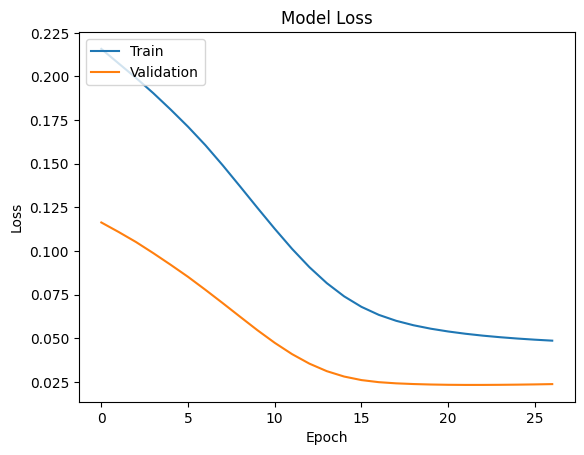

RMSE: 151.6740169237086
R-squared: -0.08313569753084238
MAPE: 2.50189250988545 

Total time:  21.479445695877075


In [ ]:
from __future__ import print_function
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Activation
from tensorflow import keras
from sklearn.metrics import mean_squared_error, r2_score
import os
from tensorflow.python.keras.callbacks import EarlyStopping
import warnings
from keras.models import load_model

warnings.filterwarnings("ignore", category=DeprecationWarning)

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

start_time = time.time()

# Reading from the database
dataset = pd.read_csv('hourly_load&weather_data.csv')
x_temperature = dataset['Temperature']
x_dewpoint = dataset['Dew Point']
x_humidity = dataset['Humidity']
x_windspeed = dataset['Wind Speed']
x_pressure = dataset['Pressure']
y = dataset['Load']

# Converting the values in the usable format
x_temperature = x_temperature.values
x_dewpoint = x_dewpoint.values
x_humidity = x_humidity.values
x_windspeed = x_windspeed.values
x_pressure = (x_pressure.values) / 29.53  # Hg to bar
y = (y.values)/1000 # MW to GW


# Visualising the independent variables
dataset_graph = plt.figure(figsize=(60, 8))
plt.plot(x_temperature[:364], label='Temperature (C)')
plt.plot(x_dewpoint[:364], label='Dew Point (C)')
plt.plot(x_humidity[:364], label='Humidity (%)')
plt.plot(x_windspeed[:364], label='Wind Speed (mph)')
plt.plot(x_pressure[:364], label='Pressure (bar)')
plt.plot(y[:364], label='Load (GW)')
plt.legend(loc='upper right')
plt.title("Dataset", fontsize=14)
plt.xlabel('Day', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.legend()
plt.show()


# Converting to a usable format in a 2D array
x_temperature = x_temperature.reshape((len(x_temperature), 1))
x_dewpoint = x_dewpoint.reshape((len(x_dewpoint), 1))
x_humidity = x_humidity.reshape((len(x_humidity), 1))
x_windspeed = x_windspeed.reshape((len(x_windspeed), 1))
x_pressure = x_pressure.reshape((len(x_pressure), 1))
y = y.reshape((len(y), 1))

print("\nIndependent & Dependent variables arrays:")
print("x_temperature:", x_temperature.shape)
print("x_dewpoint:", x_dewpoint.shape)
print("x_humidity:", x_humidity.shape)
print("x_windspeed:", x_windspeed.shape)
print("x_pressure:", x_pressure.shape)
print("y:", y.shape)

# Normalising the data using the MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
x_temperature_scaled = scaler.fit_transform(x_temperature)
x_dewpoint_scaled = scaler.fit_transform(x_dewpoint)
x_humidity_scaled = scaler.fit_transform(x_humidity)
x_windspeed_scaled = scaler.fit_transform(x_windspeed)
x_pressure_scaled = scaler.fit_transform(x_pressure)
y_scaled = scaler.fit_transform(y)


# Stacking the data columns horizontally
stacked_dataset = np.hstack(
    (x_temperature_scaled, x_dewpoint_scaled, x_humidity_scaled, x_windspeed_scaled, x_pressure_scaled, y_scaled))
print("\nStacked Dataset", stacked_dataset.shape, ":\n", stacked_dataset)


#Split a multivariate sequence into samples
def split_sequences(dataset, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(dataset)):
        start = i + n_steps_in
        end = start + n_steps_out-1
        if end > len(dataset):
            break
        x_sequence, y_sequence = dataset[i:start, :-1], dataset[start-1:end, -1]
        X.append(x_sequence)
        y.append(y_sequence)
    return np.array(X), np.array(y)

n_steps_in, n_steps_out, n_features = 30 , 15, 5
X, y = split_sequences(stacked_dataset, n_steps_in, n_steps_out)
print ("\nX.shape " , X.shape)
print ("y.shape" , y.shape)

#Splitting into training & test sets
train_X, train_y = X[:318, :], y[:318, :]
test_X, test_y = X[318:, :], y[318:, :]
print ("\ntrain_X" , train_X.shape)
print ("train_y" , train_y.shape)
print ("test_X" , test_X.shape)
print ("test_y" , test_y.shape)


#Learning Rate
opt = keras.optimizers.Adam(learning_rate=0.0001)

#GRU Model
model = Sequential()
model.add(GRU(50, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(GRU(50, activation='relu'))
model.add(Dense(n_steps_out))
model.add(Activation('linear'))
model.compile(loss='mse' , optimizer=opt , metrics=['mse'])
es = EarlyStopping(monitor="val_loss", min_delta=0, patience=5, verbose=1, mode="auto", baseline=None,
                   restore_best_weights=True)  # Stops the training when the values don't improve
history = model.fit(train_X, train_y, epochs=100, batch_size=30, verbose=1, validation_data=(test_X, test_y), callbacks=[es], shuffle=False)
print(model.summary())

# Evaluating the result
test_mse = model.evaluate(test_X, test_y, verbose=1)
# print('\nThe Mean-squared-error (MSE) on the test data set is %.6f over %d test samples.' % (test_mse, len(test_y)))
print("Test MSE:", test_mse)

# loaded_model = load_model('path')

# print("X", test_X.shape, test_X[65])
# Getting the predicted values
predicted_values = model.predict(test_X[0].reshape((1,30,5)))
scaler1 = MinMaxScaler(feature_range=(0, 1))
scaler1.fit(y)
y_pred = scaler1.inverse_transform(predicted_values)
test_scaled = scaler1.inverse_transform([test_y[0]])
y_pred = y_pred.reshape((15,))
test_scaled = test_scaled.reshape((15,))
print("P", y_pred)
print("y", test_scaled)
print("p", predicted_values, predicted_values.reshape((15,)))
print("y", test_y[0], test_y[0].shape)

# # read test data
# x_temperature = dataset['Temperature'].values
# x_dewpoint = dataset['Dew Point'].values
# x_humidity = dataset['Humidity'].values
# x_windspeed = dataset['Wind Speed'].values
# x_pressure = dataset['Pressure'].values
# y_test = dataset['Load'].values
#
# x_temperature = x_temperature[255:]
# x_dewpoint = x_dewpoint[255:]
# x_humidity = x_humidity[255:]
# x_windspeed = x_windspeed[255:]
# x_pressure = x_pressure[255:]
# y_test = y_test[255:]
#
#
# # convert to [rows, columns] structure
# x_temperature = x_temperature.reshape((len(x_temperature), 1))
# x_dewpoint = x_dewpoint.reshape((len(x_dewpoint), 1))
# x_humidity = x_humidity.reshape((len(x_humidity), 1))
# x_windspeed = x_windspeed.reshape((len(x_windspeed), 1))
# x_pressure = x_pressure.reshape((len(x_pressure), 1))
# y_test = y_test.reshape((len(y_test), 1))
#
# x_temperature_scaled = scaler.fit_transform(x_temperature)
# x_dewpoint_scaled = scaler.fit_transform(x_dewpoint)
# x_humidity_scaled = scaler.fit_transform(x_humidity)
# x_windspeed_scaled = scaler.fit_transform(x_windspeed)
# x_pressure_scaled = scaler.fit_transform(x_pressure)
#
#
# def prep_data(x_temperature_scaled, x_dewpoint_scaled, x_humidity_scaled, x_windspeed_scaled, x_pressure_scaled, y_test, start, end, last):
#     dataset_test = np.hstack((x_temperature_scaled, x_dewpoint_scaled, x_humidity_scaled, x_windspeed_scaled, x_pressure_scaled))
#     dataset_test_X = dataset_test[start:end, :]
#     test_X_new = dataset_test_X.reshape(1, dataset_test_X.shape[0], dataset_test_X.shape[1])
#
#     # prepare past and groundtruth
#     past_data = y_test[:end, :]
#     dataset_test_y = y_test[end:last, :]
#     scaler1 = MinMaxScaler(feature_range=(0, 1))
#     scaler1.fit(dataset_test_y)
#
#     # predictions
#     y_pred = model.predict(test_X_new)
#     y_pred_inv = scaler1.inverse_transform(y_pred)
#     y_pred_inv = y_pred_inv.reshape(n_steps_out, 1)
#     y_pred_inv = y_pred_inv[:, 0]
#
#     return y_pred_inv, dataset_test_y, past_data
#
#
# def evaluate_prediction(predictions, actual, model_name , start , end):
#     errors = predictions - actual
#     mse = np.square(errors).mean()
#     rmse = np.sqrt(mse)
#     mae = np.abs(errors).mean()
#
#     print("Test Data from {} to {}".format(start, end))
#     print('Mean Absolute Error: {:.2f}'.format(mae))
#     print('Root Mean Square Error: {:.2f}'.format(rmse))
#     print('')
#     print('')
#
#
#
# # Plot history and future
# def plot_multistep(history, prediction1 , groundtruth , start , end):
#     plt.figure(figsize=(20, 4))
#     y_mean = np.mean(prediction1)
#     range_history = len(history)
#     range_future = list(range(range_history, range_history + len(prediction1)))
#     plt.plot(np.arange(range_history), np.array(history), label='History')
#     plt.plot(range_future, np.array(prediction1),label='Forecasted with GRU')
#     plt.plot(range_future, np.array(groundtruth),label='GroundTruth')
#     plt.legend(loc='upper right')
#     plt.title("Test Data from {} to {} , Mean = {:.2f}".format(start, end, y_mean) ,  fontsize=18)
#     plt.xlabel('Time step' ,  fontsize=18)
#     plt.ylabel('y-value' , fontsize=18)
#
#
# for i in range(30, 60, 90):
#     start = i
#     end = start + n_steps_in
#     last = end + n_steps_out
#     y_pred_inv , dataset_test_y , past_data = prep_data(x_temperature_scaled, x_dewpoint_scaled, x_humidity_scaled, x_windspeed_scaled, x_pressure_scaled, y_test, start, end, last)
#     evaluate_prediction(y_pred_inv , dataset_test_y, 'GRU' , start , end)
#     plot_multistep(past_data , y_pred_inv , dataset_test_y , start , end)

# Plotting the results
fig = plt.figure()
plt.plot((test_y[0]))
plt.plot(predicted_values.reshape((15,)))
plt.title("GRU")
plt.xlabel('Days')
plt.ylabel('Electricity load (*1e3)')
plt.legend(('Actual', 'Predicted'), fontsize='15')
plt.show()

# Plot of the loss
loss_fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Storing the result in a file: 'load_forecasting_result.txt'


end_time = time.time()

# print("MSE:", mean_squared_error(test_y[65].reshape((1,15))*1000, predicted_values*1000))
# print("RMSE:", mean_squared_error(test_y[65].reshape((1,15))*1000, predicted_values*1000, squared=False))
# print("MSE:", mean_squared_error(test_y[0]*1000, predicted_values.reshape((15,))*1000))
# print("RMSE:", mean_squared_error(test_y[0]*1000, predicted_values.reshape((15,))*1000, squared=False))
print("RMSE:", mean_squared_error(test_scaled*1000, y_pred*1000, squared=False))
# print("R-squared:", r2_score(test_y[65].reshape((1,15))*1000, predicted_values*1000))
print("R-squared:", r2_score(test_scaled, y_pred))
print('MAPE:', np.mean(np.abs((test_scaled*1000 - y_pred*1000) / (test_scaled*1000))),'\n')
print("Total time: ", end_time - start_time)